# Part 1

## File IO (Drag in zip file to cwd)

In [ ]:
!curl https://web.archive.org/web/20210305094647/http://www2.imm.dtu.dk/~aam/datasets/imm_face_db.zip -L --output imm_face_db.zip
!mkdir imm_face_db
%cd imm_face_db
!unzip ../imm_face_db.zip
!rm imm_face_db.pdf
%cd ..

## Imports

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from google.colab import drive
drive.mount('/content/drive')

from tqdm.notebook import tqdm

import os

Mounted at /content/drive


## Code

### Dataset

In [11]:
import matplotlib.cm as cm


def show_landmarks(image, landmarks, s = 100):
  """Show image with landmarks"""
  if image.shape[0] == 1 or len(image.shape) == 2:
    image = torch.stack([image.squeeze(), image.squeeze(), image.squeeze()], dim = 0)
  color = cm.rainbow(np.linspace(0, 1, len(landmarks)))
  print(image.swapaxes(0, 1).swapaxes(1,2).shape)
  plt.imshow(image.swapaxes(0, 1).swapaxes(1,2))
  plt.scatter(landmarks[:, 0], landmarks[:, 1], s=s, marker='.', color = color)
  plt.pause(0.001)  # pause a bit so that plots are updated



def results(images, truth_landmarks, predicted_landmarks, figsize = (10, 5), s = 100):
  fig, axs = plt.subplots(2, len(images), figsize = figsize)
  
  for i, (image, truth_l, predicted_l) in \
        enumerate(zip(images, truth_landmarks, predicted_landmarks)):

    color = cm.rainbow(np.linspace(0, 1, len(truth_l)))
    if image.shape[0] == 1:
      image = torch.stack([image.squeeze(), image.squeeze(), image.squeeze()], dim = 0)
    image = image.swapaxes(0, 1).swapaxes(1,2) + .5

    axs[0, i].imshow(image)
    axs[0, i].scatter(truth_l[:, 0], truth_l[:, 1], s=s, marker='.', color = color)
    axs[1, i].imshow(image)
    axs[1, i].scatter(predicted_l[:, 0], predicted_l[:, 1], s=s, marker='.', color = color)

  axs[0,0].set_ylabel("Truth Keypoints")
  axs[1,0].set_ylabel("Predicted Keypoints")

  plt.show()


In [12]:
class keypoints_DS(Dataset):

  """
  Returns pairs of images, keypoints
  """

  def __init__(self, indices = [-6], H=None, W=None, partition = [0,1]):
    files = next(os.walk('./imm_face_db'))[2]
    files.sort()
    self.asf_files = [file for file in files if 'asf' in file]
    self.jpg_files = [file for file in files if 'jpg' in file]
    if not H:
      self.H, self.W = torchvision.io.read_image(root_dir + '/' + self.jpg_files[0]).shape[-2:]
    else:
      self.H, self.W = H, W
    self.partition = partition
    start_idx = int(partition[0] * len(self.asf_files))
    end_idx = int(partition[1] * len(self.asf_files))
    self.asf_files = self.asf_files[start_idx:end_idx]
    self.jpg_files = self.jpg_files[start_idx:end_idx]
    self.indices = indices


  def __getitem__(self, idx):
    """
    Returns data - a {image, keypoints } dict
    """

    root_dir = './imm_face_db/'

    # load all facial keypoints/landmarks
    file = open(root_dir + '/' + self.asf_files[idx])
    points = file.readlines()[16:74]
    landmark = []

    for point in points:
      x,y = point.split('\t')[2:4]
      landmark.append([float(x) - .5, float(y) - .5])

    # the nose keypoint
    if not self.indices:
      indices = [i for i in range(len(points))]
    else:
      indices = self.indices
    nose_keypoint = np.array(landmark).astype('float32')[indices].reshape(-1, 2)
    nose_keypoint = torch.tensor(nose_keypoint)

    image = torchvision.io.read_image(root_dir + '/' + self.jpg_files[idx])/255 - .5

    if self.H:
      image = transforms.functional.resize(image, [self.H, self.W])

    return self.transform({'image': image, 'keypoints': nose_keypoint})

  def __len__(self):
    return len(self.jpg_files)

  def transform(self, data):
    """
    data - a dictionary of {"image", "keypoints"}
    """

    data['image'] = transforms.functional.rgb_to_grayscale(data['image'])

    return data



In [13]:
train_ds = keypoints_DS(H = 60, W = 80, partition = [0,.8], indices = None)

data = train_ds[0]
show_landmarks(data['image'] + .5, (data['keypoints'] + .5) * torch.tensor([80, 60])) 
data['keypoints'].shape

StopIteration: ignored

### ConvNet

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



class basic_network(nn.Module):

  def __init__(self):
    super(basic_network, self).__init__()
    # 3 input image channel, 6 output channels, 5x5 square convolution
    # kernel
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 2)

  def forward(self, x):
    # Max pooling over a (2, 2) window
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    # If the size is a square, you can specify with a single number
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x.reshape(-1, 1, 2)



class better_network(nn.Module):

  def __init__(self):
    super(better_network, self).__init__()
    # 3 input image channel, 6 output channels, 5x5 square convolution
    # kernel
    self.conv1 = nn.Conv2d(1, 8, 5, stride = 2) #3x60x80 -> 8x28x38 -> 8x27x37
    self.conv2 = nn.Conv2d(8, 16, 5, stride = 2) #8x27x37 -> 16x12x17 -> 16x11x16
    self.conv3 = nn.Conv2d(16, 16, 3, stride = 2) #16x11x16 -> 16x5x7 -> 16x4x6

    self.fc1 = nn.Linear(16 * 4 * 6, 60)
    self.fc2 = nn.Linear(60, 2)

  def forward(self, x):
    # Max pooling over a (2, 2) window
    x = F.max_pool2d(F.relu(self.conv1(x)), 2, stride = 1)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2, stride = 1)
    x = F.max_pool2d(F.relu(self.conv3(x)), 2, stride = 1)
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x.reshape(-1, 1, 2)



### Trainer

In [ ]:
train_ds = keypoints_DS(H = 60, W = 80, partition = [0,.8], indices = [-6])
test_ds = keypoints_DS(H = 60, W = 80, partition = [.8, 1], indices = [-6])

dataloader = DataLoader(train_ds, batch_size=4,
                        shuffle=True, num_workers=0)

model = better_network()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

train_losses = []
test_losses = []
for epoch in tqdm(range(epochs)):
  epoch_train_losses = []
  for data in tqdm(dataloader, leave = False):
    image = data['image']
    keypoint = data['keypoints'].squeeze()

    prediction = model(image).squeeze()
    #print(prediction.shape, keypoint.shape)
    loss = loss_fn(prediction * 100, keypoint * 100)
    #print(loss)
    loss.backward()
    epoch_train_losses.append(loss.item())

    optimizer.step()
    optimizer.zero_grad()
  train_losses.append(np.mean(epoch_train_losses))

  epoch_test_losses = []
  with torch.no_grad():
    test_dataloader = DataLoader(test_ds, batch_size=1,
                            shuffle=True, num_workers=0)
    for data in tqdm(test_dataloader, leave = False):
      image = data['image']
      keypoint = data['keypoints'].squeeze()

      prediction = model(image).squeeze()
      #print(prediction.shape, keypoint.shape)
      loss = loss_fn(prediction*100, keypoint*100)
      #print(loss)
      epoch_test_losses.append(loss.item())

      optimizer.step()
      optimizer.zero_grad()
  test_losses.append(np.mean(epoch_test_losses))


### Testing

In [ ]:
plt.plot([i for i in range(len(train_losses))], train_losses, c= 'orange', label = 'Train Losses')
plt.plot([i for i in range(len(test_losses))], test_losses, c = 'cyan', label = 'Test Losses')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss on Percent of x_range, y_range')
plt.show()

We can see that this does worse with the bald guy since there are fewer features to grab onto. We can also see that the network is putting a strong prior on the middle of the image / middle of the facial area present in the image

In [ ]:
images = []
truth_landmarks = []
predicted_landmarks = []

offset = 5
idxs = [2, 38, 0, 37]
for i in idxs:
  data = test_ds[i]
  images.append(data['image'])
  truth_landmarks.append((data['keypoints'] + .5) * torch.tensor([80, 60]))
  predicted_landmarks.append((model(data['image'].unsqueeze(0)).detach() + .5).squeeze(0) * torch.tensor([80, 60]))


results(images, truth_landmarks, predicted_landmarks, figsize=(20, 5))


# Part 2

## Imports

In [15]:
!pip install -q -U albumentations

import albumentations
import cv2
from matplotlib import pyplot as plt

import albumentations as A

     |████████████████████████████████| 102 kB 5.2 MB/s 
     |████████████████████████████████| 47.6 MB 36 kB/s 


## Code

### Dataset

In [16]:
class keypoints_DS_augmented(Dataset):

  """
  Returns pairs of images, keypoints
  """

  def __init__(self, indices = [-6], H=None, W=None, partition = [0,1], augment = True):
    files = next(os.walk('./imm_face_db'))[2]
    files.sort()
    self.asf_files = [file for file in files if 'asf' in file]
    self.jpg_files = [file for file in files if 'jpg' in file]
    if not H:
      self.H, self.W = torchvision.io.read_image(root_dir + '/' + self.jpg_files[0]).shape[-2:]
    else:
      self.H, self.W = H, W
    self.partition = partition
    start_idx = int(partition[0] * len(self.asf_files))
    end_idx = int(partition[1] * len(self.asf_files))
    self.asf_files = self.asf_files[start_idx:end_idx]
    self.jpg_files = self.jpg_files[start_idx:end_idx]
    self.indices = indices
    self.augment = augment
    self.length = len(self.jpg_files)


  def __getitem__(self, idx):
    """
    Returns data - a {image, keypoints } dict
    """

    idx = idx % len(self.jpg_files)

    root_dir = './imm_face_db/'

    # load all facial keypoints/landmarks
    file = open(root_dir + '/' + self.asf_files[idx])
    points = file.readlines()[16:74]
    landmark = []

    for point in points:
      x,y = point.split('\t')[2:4]
      landmark.append([float(x) * self.W, float(y) * self.H])

    # the nose keypoint
    if not self.indices:
      indices = [i for i in range(len(points))]
    else:
      indices = self.indices
    nose_keypoint = landmark

    image = cv2.imread(root_dir + '/' + self.jpg_files[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if self.H:
      image = cv2.resize(image, [self.W, self.H])

    return self.transform({'image': image, 'keypoints': nose_keypoint})


  def __len__(self):
    return self.length


  def transform(self, data):
    """
    data - a dictionary of {"image", "keypoints"}
    """

    if self.augment:
      """
      x = torch.randint(size = (1,), low = -self.W//3, high = self.W//4)
      y = torch.randint(size = (1,), low = -self.H//3, high = self.H//4)
      data['image'] = transforms.functional.affine(data['image'], angle = 0, translate = (x,y), scale = 1, shear = 0)
      data['keypoints'] += torch.tensor([[x/self.W, y/self.H]])
      """

      # Geometric transformations / crops
      both_transform = A.Compose([
              A.Perspective(p=.3),
              A.Affine(scale=(.8, 1.2), translate_percent=(-.1, .1), rotate=(-10, 10), shear=0, p=1),
              A.Affine(scale=(.8, 1.2), translate_percent=(-.1, .1), rotate=(-35, 35), shear=(-20, 20), p=.3),
              A.CenterCrop(self.H, self.W, always_apply=True)
          ], 
          keypoint_params=A.KeypointParams(format='xy', remove_invisible=False),
      )

      # Image jittering / blurring / dropping out
      im_transform = A.Compose([
              A.Emboss(p =.2),
              A.GaussianBlur(p=.1),
              A.ColorJitter(p=.5),
              A.HueSaturationValue(p=1),
              A.GaussNoise(always_apply=True),
              A.CoarseDropout(fill_value = 255/2, max_holes=15, p = .3)
          ],
      )

      data['image'] = im_transform(image=data['image'])['image']
      data = both_transform(image=data['image'], keypoints=data['keypoints'])
      
    # Puts the image in grayscale and scales properly
    data['keypoints'] /= np.array([[self.W, self.H]])
    data['keypoints'] -= .5
    data['image'] = np.mean(data['image'], axis=2)/255 - .5
    data['image'] = torch.tensor([data['image']]).float()
    data['keypoints'] = torch.tensor(data['keypoints']).float()

    return data



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


58
torch.Size([120, 150, 3])


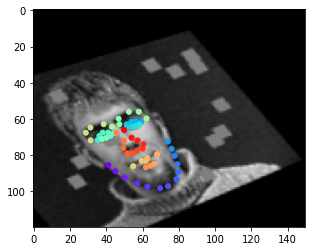

In [10]:
train_ds = keypoints_DS_augmented(H = 120, W = 150, partition = [0,.8], indices = None, augment = True)

data = train_ds[0]
print(len(data['keypoints']))
show_landmarks((data['image'] + .5), (data['keypoints'] + .5) * torch.tensor([[150, 120]])) 


### Network

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class base_keypoint_network(nn.Module):

  def __init__(self, loss_fn, device):
    super(base_keypoint_network, self).__init__()
    self.loss_fn = loss_fn
    self.device = device
    self.train_losses = []
    self.test_losses = []

  def forward(self, x):
    raise NotImplementedError

  def trainer(self, train_dataloader, test_dataloader, optimizer, epochs):
      
    for epoch in tqdm(range(epochs)):

      epoch_train_losses = []
      for data in tqdm(train_dataloader, leave = False):
        image = data['image'].to(self.device)
        keypoint = data['keypoints'].to(self.device)
        prediction = self(image)
        assert prediction.shape == keypoint.shape
        loss = self.loss_fn(prediction * 100, keypoint * 100)
        loss.backward()
        epoch_train_losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()
      self.train_losses.append(np.mean(epoch_train_losses))

      epoch_test_losses = []
      with torch.no_grad():
        for data in tqdm(test_dataloader, leave = False):
          image = data['image'].to(self.device)
          keypoint = data['keypoints'].to(self.device)
          prediction = self(image)
          assert prediction.shape == keypoint.shape
          loss = loss_fn(prediction*100, keypoint*100)
          epoch_test_losses.append(loss.item())
      self.test_losses.append(np.mean(epoch_test_losses))
    
    return self.train_losses, self.test_losses


In [18]:
class larger_network(base_keypoint_network):

  def __init__(self, loss_fn, device):
    super(larger_network, self).__init__(loss_fn, device)
    # 3 input image channel, 6 output channels, 5x5 square convolution
    # kernel
    self.conv1 = nn.Conv2d(1, 16, 7, stride = 2) #3x240x180 -> 16x117x87 -> 16x58x43
    self.conv2 = nn.Conv2d(16, 32, 5, stride = 1) #16x58x43 -> 32x54x39
    self.conv3 = nn.Conv2d(32, 32, 7, stride = 1) #32x54x39 -> 32x48x33 -> 32x24x16
    self.conv4 = nn.Conv2d(32, 64, 3, stride = 2) #32x24x16 -> 64x12x8
    self.conv5 = nn.Conv2d(64, 64, 3, stride = 2) #64x12x8 -> 64x5x3
    self.conv6 = nn.Conv2d(64, 64, 1, stride = 1) #64x5x3 -> 64x5x3


    self.fc1 = nn.Linear(64 * 5 * 3, 120)
    self.fc2 = nn.Linear(120, 58 * 2)

  def forward(self, x):
    # Max pooling over a (2, 2) window
    x = F.max_pool2d(F.relu(self.conv1(x)), 2, stride = 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(F.relu(self.conv3(x)), 2, stride = 2)
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x.reshape(-1, 58, 2)


### Trainer

In [17]:

# This should be MSE with some give at low error regions (5% error or less)
def loss_wrapper(allowed_error = 5):
  def loss_fn(output, truth):
    # diff is the percent error for each x,y prediction
    diff = torch.abs(output - truth)
    losses = torch.maximum(torch.tensor([0]).to(device), diff - allowed_error)
    return torch.mean((losses + allowed_error) ** 2)

  return loss_fn

#loss_fn = loss_wrapper(2.5) 
loss_fn = nn.MSELoss()

device = torch.device('cuda')

model = larger_network(loss_fn, device).to(device)




In [18]:
train_ds = keypoints_DS_augmented(H = 180, W = 240, partition = [0,.8], indices = None, augment=True)
train_ds.length = 1024
test_ds = keypoints_DS_augmented(H = 180, W = 240, partition = [.8, 1], indices = None, augment = False)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataloader = DataLoader(train_ds, batch_size=8,
                              shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_ds, batch_size=8,
                             shuffle=True, num_workers=2)

train_losses, test_losses = model.trainer(train_dataloader, test_dataloader, optimizer, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

### Testing

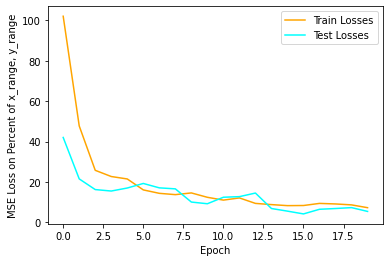

In [19]:
plt.plot([i for i in range(len(train_losses))], train_losses, c= 'orange', label = 'Train Losses')
plt.plot([i for i in range(len(test_losses))], test_losses, c = 'cyan', label = 'Test Losses')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss on Percent of x_range, y_range')
plt.show()

Here, I trained with epochs of size 1024. Each image is repeated many times with different augmentations. Here, we can see that in general, the rotated heads perform worse than the regular heads. This makes sense since keypoints get squished in a very strange fashion when the head is rotated. That being said, the performance here is better than with previous networks in that the eyes tend to be in the right spot... just the shape of keypoints relative to each other needs some work. I could probably reduce the fault tolerance in my loss to achieve this better performance. 

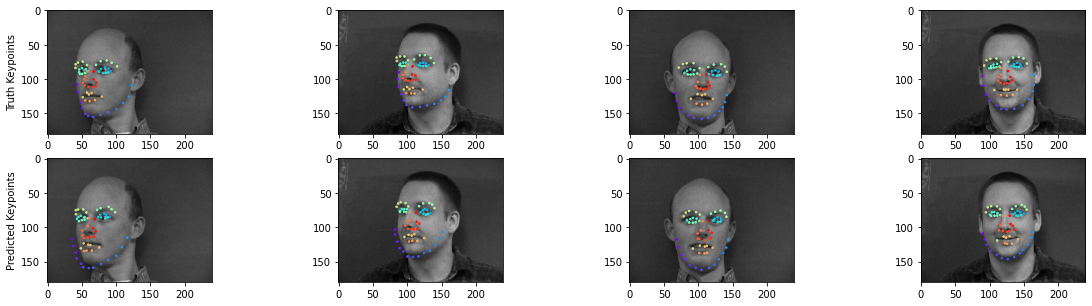

In [20]:
images = []
truth_landmarks = []
predicted_landmarks = []

offset = 5
idxs = [2, 38, 0, 37]
for i in idxs:
  data = test_ds[i]
  images.append(data['image'])
  truth_landmarks.append((data['keypoints'] + .5) * torch.tensor([240, 180]))
  predicted_landmarks.append((model(data['image'].unsqueeze(0).to(device)).detach() + .5).squeeze(0).cpu() * torch.tensor([240, 180]))

results(images, truth_landmarks, predicted_landmarks, figsize=(20, 5), s = 10)


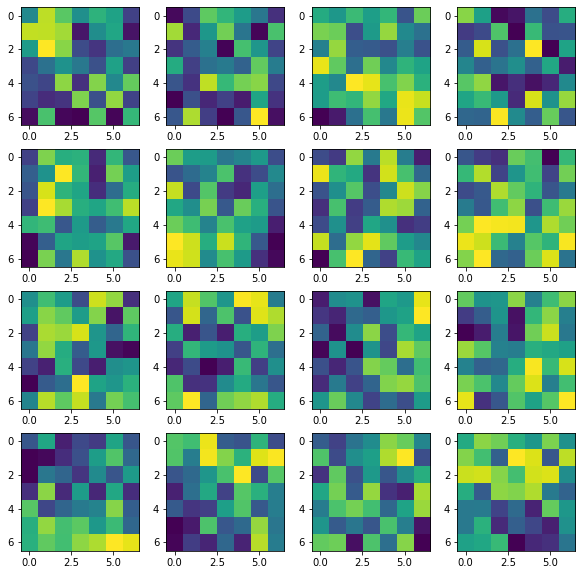

In [21]:
convolution_weights = next(model.conv1.parameters())

fig, axs = plt.subplots(4, 4, figsize = (10, 10))

for i, weight in enumerate(convolution_weights):
  weight = weight.squeeze().cpu().detach()
  axs[i//4, i%4].imshow(weight.squeeze().cpu().detach())
plt.show()

# Part 3

## File IO

In [19]:
!curl https://inst.eecs.berkeley.edu/~cs194-26/fa21/hw/proj5/labels_ibug_300W_test_parsed.xml -L --output test_parsed.xml

!wget https://people.eecs.berkeley.edu/~zhecao/ibug_300W_large_face_landmark_dataset.zip
!unzip 'ibug_300W_large_face_landmark_dataset.zip'    
!rm -r 'ibug_300W_large_face_landmark_dataset.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  128k  100  128k    0     0   221k      0 --:--:-- --:--:-- --:--:--  221k
--2021-11-16 09:46:07--  https://people.eecs.berkeley.edu/~zhecao/ibug_300W_large_face_landmark_dataset.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1792311801 (1.7G) [application/zip]
Saving to: ‘ibug_300W_large_face_landmark_dataset.zip’

          ibug_300W   0%[                    ]       0  --.-KB/s               ^C
Archive:  ibug_300W_large_face_landmark_dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile 

## Imports

In [23]:
!pip install h5py

import xml.etree.ElementTree as ET 
import numpy as np
import os
import h5py
from sklearn.decomposition import PCA

## Code

### Dataset

In [26]:
class keypoints_DS_augmented_large(Dataset):

  """
  Returns pairs of images, keypoints
  """

  def __init__(self, H=224, W=224, pad_factor = 3, partition = [0,1], augment = True, 
               grayscale = True, h5py = None):

    self.partition = partition
    self.H = H
    self.W = W
    self.pad_factor = pad_factor
    self.grayscale = grayscale

    tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
    root = tree.getroot()
    root_dir = 'ibug_300W_large_face_landmark_dataset'

    bboxes = [] # face bounding box used to crop the image
    landmarks = [] # the facial keypoints/landmarks for the whole training dataset
    img_filenames = [] # the image names for the whole dataset

    for filename in root[2]:
      img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
      box = filename[0].attrib
      # x, y for the top left corner of the box, w, h for box width and height
      bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

      landmark = []
      for num in range(68):
        x_coordinate = int(filename[0][num].attrib['x'])
        y_coordinate = int(filename[0][num].attrib['y'])
        landmark.append([x_coordinate, y_coordinate])
      landmarks.append(landmark)

    self.img_filenames = img_filenames
    self.landmarks = np.array(landmarks).astype('float32')     
    self.bboxes = np.array(bboxes).astype('float32') 

    self.start_idx = int(partition[0] * len(self.img_filenames))
    self.end_idx = int(partition[1] * len(self.img_filenames))

    self.augment = augment
    self.length = self.end_idx - self.start_idx

    self.h5py = h5py


  def create_h5py_file(self, save_file = './images_cropped.hdf5'):
    
    file = h5py.File(save_file, 'w') # open a hdf5 file
    channels = 1 if self.grayscale else 3
    image_ds = file.create_dataset('image', shape = (len(self.img_filenames), self.H, self.W, channels))
    keypoint_ds = file.create_dataset('keypoints', shape = (len(self.img_filenames), 68, 2))

    for idx, img_file in enumerate(tqdm(self.img_filenames)):

      image = cv2.imread(img_file)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      keypoints = self.landmarks[idx]
      left, top, width, height = self.bboxes[idx].astype(int)
      x_min = max(left - int(width//self.pad_factor), 0)
      x_max = min(left + width + int(width//self.pad_factor), image.shape[1] - 1)
      y_min = max(top - int(height//self.pad_factor), 0)
      y_max = min(top + height + int(height//self.pad_factor), image.shape[0] - 1)

      crop =  A.Compose([
                        A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max, always_apply=True),
                        A.Resize(self.H, self.W)],
                        keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

      data = crop(image = image, keypoints = keypoints)

      if self.grayscale:
        data['image'] = np.mean(data['image'], axis = -1).expand_dims(-1)

      image_ds[idx] = data['image']
      keypoint_ds[idx] = data['keypoints']
    
    file.close()
    file = h5py.File(save_file, 'r')
    self.h5py = file


  def __getitem__(self, idx):
    """
    Returns data - a {image, keypoints} dict
    """
    if not self.h5py:
      idx = (idx % (self.end_idx - self.start_idx)) + self.start_idx

      image = cv2.imread(self.img_filenames[idx])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      keypoints = self.landmarks[idx]
      left, top, width, height = self.bboxes[idx].astype(int)
      x_min = max(left - int(width//self.pad_factor), 0)
      x_max = min(left + width + int(width//self.pad_factor), image.shape[1] - 1)
      y_min = max(top - int(height//self.pad_factor), 0)
      y_max = min(top + height + int(height//self.pad_factor), image.shape[0] - 1)

      crop =  A.Compose([
                        A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max, always_apply=True),
                        A.Resize(self.H, self.W)],
                        keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
      data = crop(image = image, keypoints = keypoints)
    
    else:
      idx = (idx % (self.end_idx - self.start_idx)) + self.start_idx
      data = {'image': self.h5py['image'][idx].astype(np.uint8), 
              'keypoints': self.h5py['keypoints'][idx].astype(np.float32)}

    return self.transform(data)


  def __len__(self):
    return self.length


  def transform(self, data):
    """
    data - a dictionary of {"image", "keypoints"}
    """


    if self.augment:
      """
      x = torch.randint(size = (1,), low = -self.W//3, high = self.W//4)
      y = torch.randint(size = (1,), low = -self.H//3, high = self.H//4)
      data['image'] = transforms.functional.affine(data['image'], angle = 0, translate = (x,y), scale = 1, shear = 0)
      data['keypoints'] += torch.tensor([[x/self.W, y/self.H]])
      """

      # Geometric transformations / crops
      both_transform = A.Compose([
              A.Perspective(p=.3),
              A.Affine(scale=(.8, 1.2), translate_percent=(-.1, .1), rotate=(-10, 10), shear=0, p=1, fit_output = False),
              A.Affine(scale=(.8, 1.2), translate_percent=(-.1, .1), rotate=(-35, 35), shear=(-20, 20), p=.4, fit_output = False),
              A.CenterCrop(self.H, self.W, always_apply=True)
          ], 
          keypoint_params=A.KeypointParams(format='xy', remove_invisible=False),
      )

      # Image jittering / blurring / dropping out
      im_transform = A.Compose([
              A.Emboss(p =.2),
              A.GaussianBlur(p=.1),
              A.ColorJitter(p=.5),
              A.HueSaturationValue(p=1),
              A.GaussNoise(always_apply=True),
              A.CoarseDropout(fill_value = 255/2, max_holes=15, p = .3)
          ],
      )

      data['image'] = im_transform(image=data['image'])['image']
      data = both_transform(image=data['image'], keypoints=data['keypoints'])
      
    # Puts the image in grayscale and scales properly
    if not self.grayscale:
      data['keypoints'] /= np.array([[self.W, self.H]])
      data['keypoints'] -= .5
      data['keypoints'] = torch.tensor(data['keypoints']).float()
      data['image'] = data['image'].swapaxes(1,2).swapaxes(0,1)
      data['image'] = torch.tensor(data['image']).float()
      data['image'] = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])(data['image']/255)

    else:
      data['keypoints'] /= np.array([[self.W, self.H]])
      data['keypoints'] -= .5
      data['keypoints'] = torch.tensor(data['keypoints']).float()
      data['image'] = data['image'].swapaxes(1,2).swapaxes(0,1)
      data['image'] = torch.tensor([data['image']]).float()
      data['image'] = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])(data['image']/255)
      data['image'] = torch.mean(data['image'], dim=0)

    return data






class PCA_keypoints_DS_augmented_large(keypoints_DS_augmented_large):

  def __init__(self, H=224, W=224, pad_factor = 3, partition = [0,1], augment = True, 
               grayscale = True, h5py = None, PCA_components = 4, pca_data_iterations=2, pca = None):
    super().__init__(H=H, W=W, pad_factor=pad_factor, partition=partition, 
                     augment=augment, grayscale=grayscale, h5py=h5py)
    self.pca = PCA(n_components=PCA_components) if not pca else pca
    
    if not pca:
      length_placeholder = self.length
      self.length *= pca_data_iterations
      keypoints = []
      print("Applying PCA to keypoints")
      for iter in range(pca_data_iterations):
        for idx in tqdm(range(self.start_idx, self.end_idx)):
          data = super().__getitem__(idx)
          keypoint = data['keypoints'].flatten().numpy()
          keypoints.append(keypoint)
      X = np.stack(keypoints)
      self.pca.fit(X)
      self.length = length_placeholder


  def __getitem__(self, idx):
    data = super().__getitem__(idx)
    data['keypoints'] = torch.tensor(self.pca.transform(data['keypoints'].reshape(-1, 68*2))).squeeze()
    return data




In [27]:
"""train_ds = keypoints_DS_augmented_large(pad_factor = 2, partition = [0,.8], augment = True, grayscale = False)
train_ds.create_h5py_file()
"""

'train_ds = keypoints_DS_augmented_large(pad_factor = 2, partition = [0,.8], augment = True, grayscale = False)\ntrain_ds.create_h5py_file()\n'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


68
torch.Size([3, 224, 224])
torch.Size([224, 224, 3])


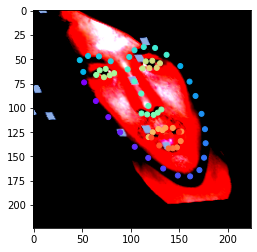

In [32]:
train_ds_test = keypoints_DS_augmented_large(pad_factor = 2, partition = [0,.8], augment = True, grayscale = False)

i = 4
data = train_ds_test[i]
print(len(data['keypoints']))
print(data['image'].shape)
show_landmarks((data['image'].squeeze() + .5), (data['keypoints'] + .5) * torch.tensor([[224, 224]])) 
_=1

In [ ]:
# Testing PCA dataset with 99% reconstruction

#train_ds.h5py = train_ds.h5py
train_ds = keypoints_DS_augmented_large(H = 224, W = 224, partition = [0,.9], augment=True, grayscale = False)
train_ds.create_h5py_file()

train_ds_pca = PCA_keypoints_DS_augmented_large(H = 224, W = 224, partition = [0,.9], augment=True, grayscale = False, PCA_components = 12, pca_data_iterations=2, h5py = train_ds.h5py)


pca = train_ds_pca.pca
data = train_ds_pca[0]

show_landmarks((data['image'].squeeze() + .5), (pca.inverse_transform(data['keypoints'].reshape(1, -1)) + .5).reshape(68, 2) * np.array([[224, 224]])) 



  0%|          | 0/6666 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### Network (Regular)

In [33]:
network = torchvision.models.resnet18(pretrained = True)
#network.conv1 = nn.Conv2d(1, 64, 7, stride = 2, padding = (3, 3), bias = False)
network.fc = nn.Linear(512, 68 * 2)

def training_resnet(self, train_dataloader, test_dataloader, optimizer, epochs):
    
  for epoch in tqdm(range(epochs)):

    epoch_train_losses = []
    for data in tqdm(train_dataloader, leave = False):
      image = data['image'].to(self.device)
      keypoint = data['keypoints'].to(self.device)
      prediction = self(image).reshape(-1, 68, 2).to(self.device)
      #print(prediction.shape, keypoint.shape)
      assert prediction.shape == keypoint.shape
      loss = self.loss_fn(prediction * 100, keypoint * 100)
      loss.backward()
      epoch_train_losses.append(loss.item())
      optimizer.step()
      optimizer.zero_grad()
    self.train_losses.append(np.mean(epoch_train_losses))

    epoch_test_losses = []
    with torch.no_grad():
      for data in tqdm(test_dataloader, leave = False):
        image = data['image'].to(self.device)
        keypoint = data['keypoints'].to(self.device)
        prediction = self(image).reshape(-1, 68, 2).to(self.device)
        assert prediction.shape == keypoint.shape
        loss = loss_fn(prediction * 100, keypoint * 100)
        epoch_test_losses.append(loss.item())
    self.test_losses.append(np.mean(epoch_test_losses))
    if np.mean(epoch_test_losses) < min(self.test_losses):
      torch.save(self.state_dict(), '/content/drive/MyDrive/Project5/best_val_losses.pt')

  
  return self.train_losses, self.test_losses

network.training_resnet = training_resnet.__get__(network)



"""
#PCA NETWORK

pca_components = 12
network = torchvision.models.resnet18(pretrained = True)
#network.conv1 = nn.Conv2d(1, 64, 7, stride = 2, padding = (3, 3), bias = False)
network.fc = nn.Linear(512, pca_components)

def training_resnet(self, train_dataloader, test_dataloader, optimizer, epochs):
    
  for epoch in tqdm(range(epochs)):

    epoch_train_losses = []
    for data in tqdm(train_dataloader, leave = False):
      image = data['image'].to(self.device)
      keypoint = data['keypoints'].to(self.device)
      prediction = self(image)
      #print(prediction.shape, keypoint.shape)
      assert prediction.shape == keypoint.shape
      loss = self.loss_fn(prediction * 100, keypoint * 100)
      loss.backward()
      epoch_train_losses.append(loss.item())
      optimizer.step()
      optimizer.zero_grad()
    self.train_losses.append(np.mean(epoch_train_losses))

    epoch_test_losses = []
    with torch.no_grad():
      for data in tqdm(test_dataloader, leave = False):
        image = data['image'].to(self.device)
        keypoint = data['keypoints'].to(self.device)
        prediction = self(image).cpu()
        prediction = torch.tensor(train_dataloader.dataset.pca.inverse_transform(prediction))
        prediction = prediction.reshape(-1, 68, 2).to(self.device)
        assert prediction.shape == keypoint.shape
        loss = loss_fn(prediction * 100, keypoint * 100)
        epoch_test_losses.append(loss.item())
    self.test_losses.append(np.mean(epoch_test_losses))
  
  return self.train_losses, self.test_losses

network.training_resnet = training_resnet.__get__(network)



"""

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

"\n#PCA NETWORK\n\npca_components = 12\nnetwork = torchvision.models.resnet18(pretrained = True)\n#network.conv1 = nn.Conv2d(1, 64, 7, stride = 2, padding = (3, 3), bias = False)\nnetwork.fc = nn.Linear(512, pca_components)\n\ndef training_resnet(self, train_dataloader, test_dataloader, optimizer, epochs):\n    \n  for epoch in tqdm(range(epochs)):\n\n    epoch_train_losses = []\n    for data in tqdm(train_dataloader, leave = False):\n      image = data['image'].to(self.device)\n      keypoint = data['keypoints'].to(self.device)\n      prediction = self(image)\n      #print(prediction.shape, keypoint.shape)\n      assert prediction.shape == keypoint.shape\n      loss = self.loss_fn(prediction * 100, keypoint * 100)\n      loss.backward()\n      epoch_train_losses.append(loss.item())\n      optimizer.step()\n      optimizer.zero_grad()\n    self.train_losses.append(np.mean(epoch_train_losses))\n\n    epoch_test_losses = []\n    with torch.no_grad():\n      for data in tqdm(test_dataload

### Training (Regular)

In [34]:
# This should be MSE with some give at low error regions (5% error or less)
def loss_wrapper(allowed_error = 5):
  def loss_fn(output, truth):
    # diff is the percent error for each x,y prediction
    diff = torch.abs(output - truth)
    losses = torch.maximum(torch.tensor([0]).to(device), diff - allowed_error)
    return torch.mean((losses + allowed_error) ** 2)

  return loss_fn

#loss_fn = loss_wrapper(2.5) 
loss_fn = nn.MSELoss()

device = torch.device('cuda')

model = network.to(device) #larger_network(loss_fn, device).to(device)

model.device = device
model.loss_fn = loss_fn
model.train_losses = []
model.test_losses = []


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


68
torch.Size([3, 224, 224])
torch.Size([224, 224, 3])


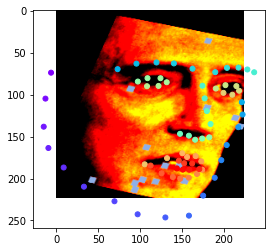

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

In [ ]:
"""
train_ds = keypoints_DS_augmented_large(H = 224, W = 224, partition = [0, .9], augment=True, grayscale = False, pad_factor = float('inf'))
train_ds.create_h5py_file(save_file = 'train.hdf5')

test_ds = keypoints_DS_augmented_large(H = 224, W = 224, partition = [.9, 1], augment = False, grayscale = False, pad_factor = float('inf'))
test_ds.create_h5py_file(save_file = 'test.hdf5')
"""
i = 0
data = train_ds[i]
print(len(data['keypoints']))
print(data['image'].shape)
show_landmarks((data['image'].squeeze() + .5), (data['keypoints'] + .5) * torch.tensor([[224, 224]])) 

params = [param for param in model.fc.parameters()] + [param for param in model.layer4.parameters()]
params = [{'params': model.fc.parameters(), 'lr': .001}, 
          {'params': model.layer4.parameters(), 'lr': .001}, 
          {'params': model.layer3.parameters(), 'lr': .0001}
          ]
for param in model.parameters():
  param.requires_grad = False

for param in model.fc.parameters():
  param.requires_grad = True
for param in model.layer4.parameters():
  param.requires_grad = True
for param in model.layer3.parameters():
  param.requires_grad = True


optimizer = optim.Adam(params, lr=.001)
train_dataloader = DataLoader(train_ds, batch_size=32,
                              shuffle=False, num_workers=2, persistent_workers = True)
test_dataloader = DataLoader(test_ds, batch_size=8,
                             shuffle=False, num_workers=2)

train_losses, test_losses = model.training_resnet(train_dataloader, test_dataloader, optimizer, 20)
"""

optimizer = optim.Adam(params, lr=0.0001)
train_dataloader = DataLoader(train_ds, batch_size=32,
                              shuffle=False, num_workers=2, persistent_workers = True)
test_dataloader = DataLoader(test_ds, batch_size=8,
                             shuffle=False, num_workers=2)

train_losses, test_losses = model.training_resnet(train_dataloader, test_dataloader, optimizer, 20)
"""

In [43]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Testing (Regular)

In [1]:
plt.plot([i for i in range(len(model.train_losses))], model.train_losses, c= 'orange', label = 'Train Losses')
plt.plot([i for i in range(len(model.test_losses))], model.test_losses, c = 'cyan', label = 'Test Losses')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss on Percent of x_range, y_range')
plt.show()

plt.plot([i for i in range(3, len(model.train_losses))], model.train_losses[3:], c= 'orange', label = 'Train Losses')
plt.plot([i for i in range(3, len(model.test_losses))], model.test_losses[3:], c = 'cyan', label = 'Test Losses')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss on Percent of x_range, y_range')
plt.show()

print("Train Losses", min(model.train_losses))
print("Test Losses", min(model.test_losses))


NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


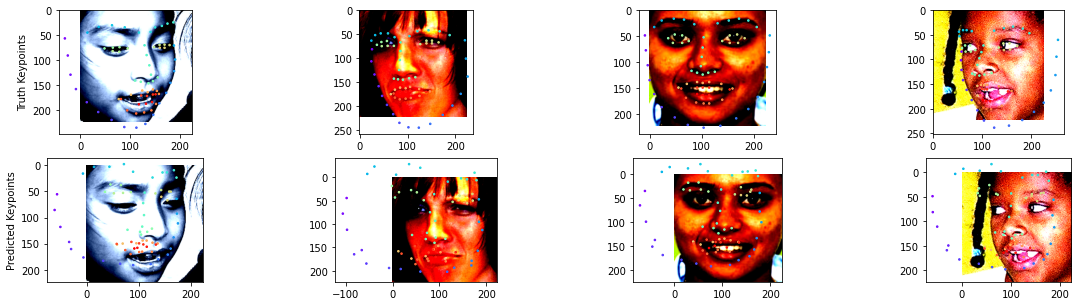

In [45]:
images = []
truth_landmarks = []
predicted_landmarks = []

offset = 5
idxs = [2, 38, 0, 37]
for i in idxs:
  data = test_ds[i]
  images.append(data['image'])
  truth_landmarks.append((data['keypoints'] + .5) * torch.tensor([224, 224]))
  predicted_landmarks.append(torch.tanh( model(data['image'].unsqueeze(0).to(device)).detach() + .5).reshape(68, 2).cpu() * torch.tensor([224, 224]))

results(images, truth_landmarks, predicted_landmarks, figsize=(20, 5), s = 10)


In [ ]:
class val_ds(Dataset):

  """
  Returns pairs of images, keypoints
  """

  def __init__(self, H=224, W=224, pad_factor = 3, partition = [0,1], augment = True, 
               grayscale = True, h5py = None):

    self.partition = partition
    self.H = H
    self.W = W
    self.pad_factor = pad_factor
    self.grayscale = grayscale

    tree = ET.parse('test_parsed.xml')
    root = tree.getroot()
    root_dir = '/content/ibug_300W_large_face_landmark_dataset'

    bboxes = [] # face bounding box used to crop the image
    landmarks = [] # the facial keypoints/landmarks for the whole training dataset
    img_filenames = [] # the image names for the whole dataset

    for filename in root[2]:
      img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
      box = filename[0].attrib
      # x, y for the top left corner of the box, w, h for box width and height
      bboxes.append([box['left'], box['top'], box['width'], box['height']]) 



    self.img_filenames = img_filenames
    self.bboxes = np.array(bboxes).astype('float32') 

    self.start_idx = int(partition[0] * len(self.img_filenames))
    self.end_idx = int(partition[1] * len(self.img_filenames))

    self.augment = False
    self.length = self.end_idx - self.start_idx

    self.h5py = False



  def __getitem__(self, idx):
    """
    Returns data - a {image, keypoints} dict
    """

    idx = (idx % (self.end_idx - self.start_idx)) + self.start_idx

    image = cv2.imread(self.img_filenames[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    left, top, width, height = self.bboxes[idx].astype(int)
    x_min = max(left - int(width//self.pad_factor), 0)
    x_max = min(left + width + int(width//self.pad_factor), image.shape[1] - 1)
    y_min = max(top - int(height//self.pad_factor), 0)
    y_max = min(top + height + int(height//self.pad_factor), image.shape[0] - 1)

    crop =  A.Compose([
                      A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max, always_apply=True),
                      A.Resize(self.H, self.W)])
    data = crop(image = image)
  

    return self.transform(data)


  def __len__(self):
    return self.length


  def transform(self, data):
    """
    data - a dictionary of {"image", "keypoints"}
    """


    if self.augment:
      """
      x = torch.randint(size = (1,), low = -self.W//3, high = self.W//4)
      y = torch.randint(size = (1,), low = -self.H//3, high = self.H//4)
      data['image'] = transforms.functional.affine(data['image'], angle = 0, translate = (x,y), scale = 1, shear = 0)
      data['keypoints'] += torch.tensor([[x/self.W, y/self.H]])
      """

      # Geometric transformations / crops
      both_transform = A.Compose([
              A.Perspective(p=.3),
              A.Affine(scale=(.8, 1.2), translate_percent=(-.1, .1), rotate=(-10, 10), shear=0, p=1, fit_output = False),
              A.Affine(scale=(.8, 1.2), translate_percent=(-.1, .1), rotate=(-35, 35), shear=(-20, 20), p=.4, fit_output = False),
              A.CenterCrop(self.H, self.W, always_apply=True)
          ], 
          keypoint_params=A.KeypointParams(format='xy', remove_invisible=False),
      )

      # Image jittering / blurring / dropping out
      im_transform = A.Compose([
              A.Emboss(p =.2),
              A.GaussianBlur(p=.1),
              A.ColorJitter(p=.5),
              A.HueSaturationValue(p=1),
              A.GaussNoise(always_apply=True),
              A.CoarseDropout(fill_value = 255/2, max_holes=15, p = .3)
          ],
      )

      data['image'] = im_transform(image=data['image'])['image']
      data = both_transform(image=data['image'], keypoints=data['keypoints'])
      
    # Puts the image in grayscale and scales properly
    if not self.grayscale:
      data['image'] = data['image'].swapaxes(1,2).swapaxes(0,1)
      data['image'] = torch.tensor(data['image']).float()
      data['image'] = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])(data['image']/255)

    else:
      data['image'] = data['image'].swapaxes(1,2).swapaxes(0,1)
      data['image'] = torch.tensor([data['image']]).float()
      data['image'] = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])(data['image']/255)
      data['image'] = torch.mean(data['image'], dim=0)

    return data

In [ ]:
predicted_landmarks = []
validation_ds = val_ds(augment = False, grayscale = False, pad_factor = float('inf'))
for i in tqdm(range(len(validation_ds))):
  data = validation_ds[i]
  image = data['image']
  left, top, width, height = validation_ds.bboxes[i].astype(int)
  prediction = torch.tanh(model(image.unsqueeze(0).to(device)).detach() + .5).reshape(68, 2).cpu() * torch.tensor([width, height]) + torch.tensor([left, top])
  predicted_landmarks.append(prediction.numpy())

landmarks = []
for i in tqdm(range(len(predicted_landmarks))):
  for keypoint in range(68):
    landmarks.append(predicted_landmarks[i][keypoint,0])
    landmarks.append(predicted_landmarks[i][keypoint,1])
ids = [i for i in range(len(landmarks))]


  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/1008 [00:00<?, ?it/s]

In [ ]:
import csv
with open('validation_outs.csv', 'w') as f:
    
    # using csv.writer method from CSV package
    write = csv.writer(f)

    write.writerow(['Id', 'Predicted'])
    for row in zip(ids, landmarks):      
        write.writerow(row)

(790, 640, 3)


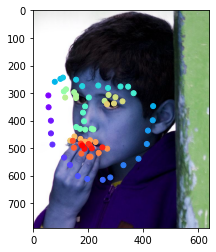

In [ ]:
import csv
validation_ds = val_ds(augment = False, grayscale = False, pad_factor = float('inf'))
with open('validation_outs.csv', 'r') as f:
  reader = csv.reader(f)
  data = list(reader)


predictions = []
for i in range(1, 69 + 68):
  idx = 0
  left, top, width, height = validation_ds.bboxes[idx].astype(int)
  predictions.append(float(data[i][1]))

show_landmarks(cv2.imread(validation_ds.img_filenames[0]).swapaxes(1,2).swapaxes(0,1), np.array(predictions).reshape(68, 2))


### Networks (PCA)

In [ ]:
"""
network = torchvision.models.resnet18(pretrained = True)
#network.conv1 = nn.Conv2d(1, 64, 7, stride = 2, padding = (3, 3), bias = False)
network.fc = nn.Linear(512, 68 * 2)

def training_resnet(self, train_dataloader, test_dataloader, optimizer, epochs):
    
  for epoch in tqdm(range(epochs)):

    epoch_train_losses = []
    for data in tqdm(train_dataloader, leave = False):
      image = data['image'].to(self.device)
      keypoint = data['keypoints'].to(self.device)
      prediction = self(image).reshape(-1, 68, 2).to(self.device)
      prediction = torch.tanh( (1/2) * prediction )
      #print(prediction.shape, keypoint.shape)
      assert prediction.shape == keypoint.shape
      loss = self.loss_fn(prediction * 100, keypoint * 100)
      loss.backward()
      epoch_train_losses.append(loss.item())
      optimizer.step()
      optimizer.zero_grad()
    self.train_losses.append(np.mean(epoch_train_losses))

    epoch_test_losses = []
    with torch.no_grad():
      for data in tqdm(test_dataloader, leave = False):
        image = data['image'].to(self.device)
        keypoint = data['keypoints'].to(self.device)
        prediction = self(image).reshape(-1, 68, 2).to(self.device)
        prediction = torch.tanh( (1/2) * prediction )
        assert prediction.shape == keypoint.shape
        loss = loss_fn(prediction * 100, keypoint * 100)
        epoch_test_losses.append(loss.item())
    self.test_losses.append(np.mean(epoch_test_losses))
  
  return self.train_losses, self.test_losses

network.training_resnet = training_resnet.__get__(network)

"""



#PCA NETWORK

pca_components = 12
network = torchvision.models.resnet18(pretrained = True)
#network.conv1 = nn.Conv2d(1, 64, 7, stride = 2, padding = (3, 3), bias = False)
network.fc = nn.Linear(512, pca_components)

def training_resnet(self, train_dataloader, test_dataloader, optimizer, epochs):
    
  for epoch in tqdm(range(epochs)):

    epoch_train_losses = []
    for data in tqdm(train_dataloader, leave = False):
      image = data['image'].to(self.device)
      keypoint = data['keypoints'].to(self.device)
      prediction = self(image)
      #print(prediction.shape, keypoint.shape)
      assert prediction.shape == keypoint.shape
      loss = self.loss_fn(prediction * 100, keypoint * 100)
      loss.backward()
      epoch_train_losses.append(loss.item())
      optimizer.step()
      optimizer.zero_grad()
    self.train_losses.append(np.mean(epoch_train_losses))

    epoch_test_losses = []
    with torch.no_grad():
      for data in tqdm(test_dataloader, leave = False):
        image = data['image'].to(self.device)
        keypoint = data['keypoints'].to(self.device)
        prediction = self(image).cpu()
        prediction = torch.tensor(train_dataloader.dataset.pca.inverse_transform(prediction))
        prediction = prediction.reshape(-1, 68, 2).to(self.device)
        assert prediction.shape == keypoint.shape
        loss = loss_fn(prediction * 100, keypoint * 100)
        epoch_test_losses.append(loss.item())
    self.test_losses.append(np.mean(epoch_test_losses))
  
  return self.train_losses, self.test_losses

network.training_resnet = training_resnet.__get__(network)






### Training (PCA)

In [ ]:
# This should be MSE with some give at low error regions (5% error or less)
def loss_wrapper(allowed_error = 5):
  def loss_fn(output, truth):
    # diff is the percent error for each x,y prediction
    diff = torch.abs(output - truth)
    losses = torch.maximum(torch.tensor([0]).to(device), diff - allowed_error)
    return torch.mean((losses + allowed_error) ** 2)

  return loss_fn

#loss_fn = loss_wrapper(2.5) 
loss_fn = nn.MSELoss()

device = torch.device('cuda')

model = network.to(device) #larger_network(loss_fn, device).to(device)

model.device = device
model.loss_fn = loss_fn
model.train_losses = []
model.test_losses = []


In [ ]:
"""
train_ds = keypoints_DS_augmented_large(H = 224, W = 224, partition = [0, .9], augment=True, grayscale = False)
train_ds.create_h5py_file(save_file = 'train.hdf5')
train_ds = PCA_keypoints_DS_augmented_large(H = 224, W = 224, partition = [0, .9], augment=True, grayscale = False, PCA_components = 12, pca_data_iterations=2, h5py = train_ds.h5py)

test_ds = keypoints_DS_augmented_large(H = 224, W = 224, partition = [.9, 1], augment = False, grayscale = False, pad_factor = float('inf'))
test_ds.create_h5py_file(save_file = 'test.hdf5')
#test_ds = PCA_keypoints_DS_augmented_large(H = 224, W = 224, partition = [.9, 1], augment=False, grayscale = False, pca = train_ds.pca, h5py = test_ds.h5py)
"""

"""
i = 0
data = train_ds[i]
print(len(data['keypoints']))
print(data['image'].shape)
show_landmarks((data['image'].squeeze() + .5), (data['keypoints'] + .5) * torch.tensor([[224, 224]])) 
"""

params = [param for param in model.fc.parameters()] + [param for param in model.layer4.parameters()]
for param in model.parameters():
  param.requires_grad = False
for param in params:
  param.requires_grad = True
optimizer = optim.Adam(params, lr=0.001)

train_dataloader = DataLoader(train_ds, batch_size=32,
                              shuffle=False, num_workers=2, persistent_workers = True)
test_dataloader = DataLoader(test_ds, batch_size=8,
                             shuffle=False, num_workers=2)

train_losses, test_losses = model.training_resnet(train_dataloader, test_dataloader, optimizer, 40)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

### Testing (PCA)

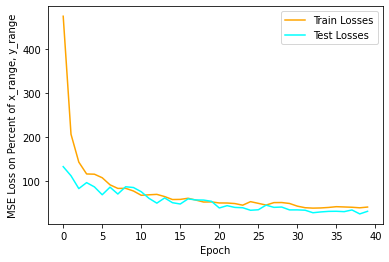

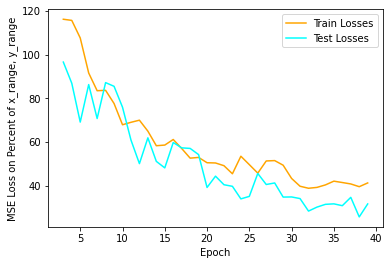

Train Losses 38.76589292161008
Test Losses 25.64076939083281


In [ ]:
plt.plot([i for i in range(len(train_losses))], train_losses, c= 'orange', label = 'Train Losses')
plt.plot([i for i in range(len(test_losses))], test_losses, c = 'cyan', label = 'Test Losses')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss on Percent of x_range, y_range')
plt.show()

plt.plot([i for i in range(3, len(train_losses))], train_losses[3:], c= 'orange', label = 'Train Losses')
plt.plot([i for i in range(3, len(test_losses))], test_losses[3:], c = 'cyan', label = 'Test Losses')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss on Percent of x_range, y_range')
plt.show()

print("Train Losses", min(train_losses))
print("Test Losses", min(test_losses))


Here, I trained with epochs of size 1024. Each image is repeated many times with different augmentations. Here, we can see that in general, the rotated heads perform worse than the regular heads. This makes sense since keypoints get squished in a very strange fashion when the head is rotated. That being said, the performance here is better than with previous networks in that the eyes tend to be in the right spot... just the shape of keypoints relative to each other needs some work. I could probably reduce the fault tolerance in my loss to achieve this better performance. 

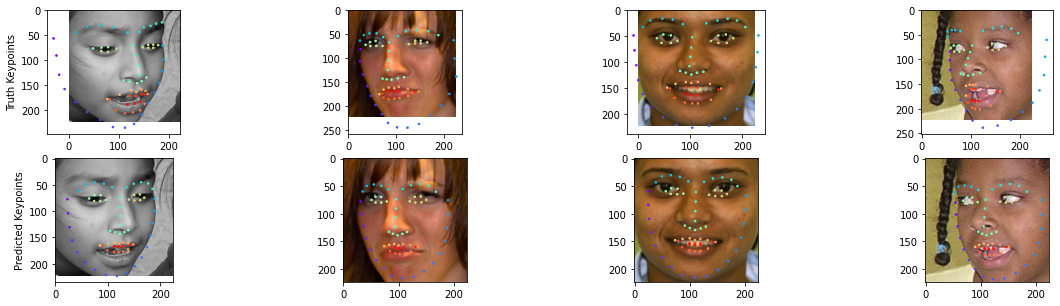

In [ ]:
images = []
truth_landmarks = []
predicted_landmarks = []

offset = 5
idxs = [2, 38, 0, 37]
for i in idxs:
  data = test_ds[i]
  images.append(data['image'])
  truth_landmarks.append((data['keypoints'] + .5) * torch.tensor([224, 224]))
  temp = train_ds.pca.inverse_transform(model(data['image'].unsqueeze(0).to(device)).cpu().detach())
  predicted_landmarks.append((temp + .5).reshape(68, 2) * np.array([224, 224]))

results(images, truth_landmarks, predicted_landmarks, figsize=(20, 5), s = 10)


# Misc

In [ ]:
images_paths = ['img1.PNG', 'img2.PNG', 'img3.PNG', 'img4.jpeg']
images = []
for image in images_paths:
  image = cv2.imread(image)
  image = torch.tensor(cv2.cvtColor(image, cv2.COLOR_BGR2RGB).swapaxes(1,2).swapaxes(0,1))
  image = transforms.Resize((224, 224))(image)/255 - .5
  images.append(image)
#model.load_state_dict(torch.load('weights_20.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

torch.Size([224, 224, 3])


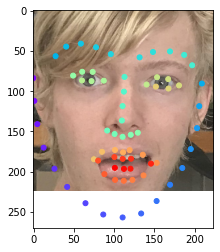

In [ ]:
i = 3
with torch.no_grad():
  show_landmarks(images[i] + .5, 224 * (torch.tanh(.5 * model(images[i].to(device).unsqueeze(0))) + .5).cpu().reshape(68, 2))


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  128k  100  128k    0     0   286k      0 --:--:-- --:--:-- --:--:--  287k


In [ ]:
test = 3

In [ ]:
test = 3